# Final Product - Coffee Quality Visualizations (Code)

**Name**: Angel Lai

**Computing ID**: Bpy2nc


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output, display

In [2]:
df = pd.read_csv("df_arabica_clean.csv")

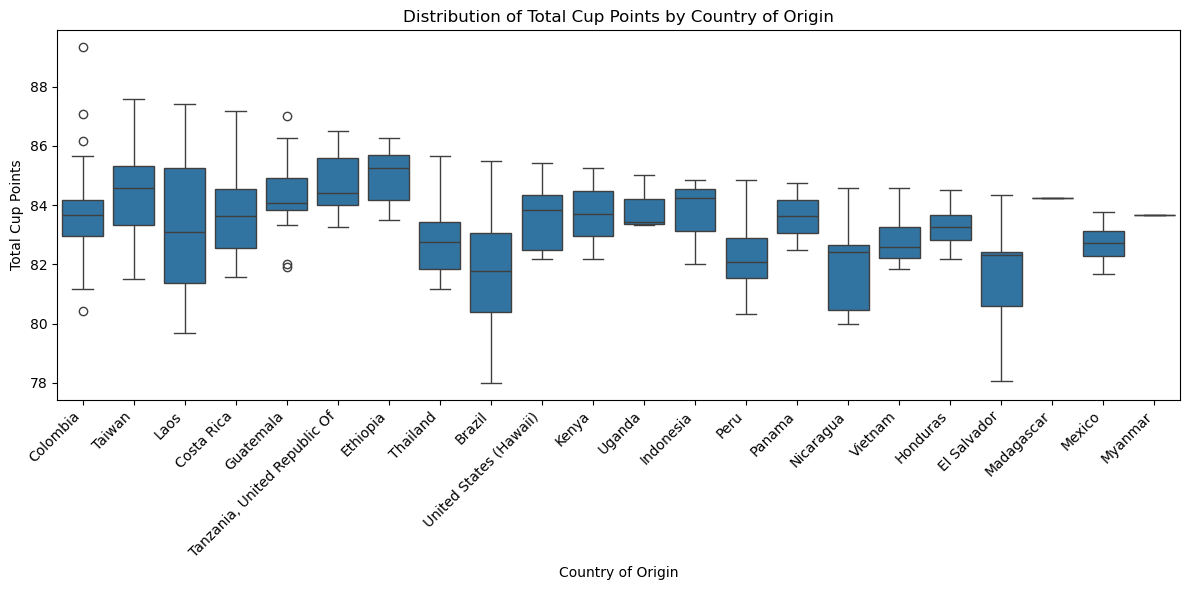

In [5]:
plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    data=df,
    x="Country of Origin",
    y="Total Cup Points"
)

ax.set_title("Distribution of Total Cup Points by Country of Origin")
ax.set_xlabel("Country of Origin")
ax.set_ylabel("Total Cup Points")

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Analysis: This boxplot shows how Total Cup Points (overall quality scores assigned by professional tasters) vary by Country of Origin. Each point in the underlying dataset is one coffee lot, and its Total Cup Points is a summary of multiple sensory attributes like aroma, flavor, acidity, body, and balance. Grouping by country lets us compare the quality distributions of coffees from different origins.

Each box represents the distribution of scores for one country. The horizontal line inside the box is the median (the typical score), the top and bottom of the box show the 75th and 25th percentiles (the middle 50% of coffees), and the “whiskers” extend toward the more extreme values. Any individual dots beyond the whiskers would be outliers, representing unusually high- or low-scoring lots. For some countries (like Madagascar and Myanmar in this dataset), there is only one coffee sample; in those cases, the boxplot collapses to a single horizontal line because there isn’t enough data to form a full distribution (only one data point).

This visualization helps compare both the typical quality and the consistency of coffees by origin. Countries with higher medians tend to produce higher-scoring coffees overall, while countries with taller boxes or longer whiskers show more variation in quality. Countries with shorter boxes and whiskers are more consistent. Interpreting the plot this way allows us to see which origins not only reach high scores but also how reliably they do so across different lots.

In [6]:
country_widget = widgets.Dropdown(
    options=['All'] + sorted(df['Country of Origin'].dropna().unique().tolist()),
    description='Country:'
)

score_widget = widgets.FloatRangeSlider(
    value=[df['Total Cup Points'].min(), df['Total Cup Points'].max()],
    min=df['Total Cup Points'].min(),
    max=df['Total Cup Points'].max(),
    step=0.1,
    description='Score range:'
)

def flavor_explorer(country, score_range):
    df2 = df.copy()
    
    # filter by score
    df2 = df2[
        (df2['Total Cup Points'] >= score_range[0]) &
        (df2['Total Cup Points'] <= score_range[1])
    ]
    
    # filter by country (if not 'All')
    if country != 'All':
        df2 = df2[df2['Country of Origin'] == country]
    
    g = sns.relplot(
        data=df2,
        x='Acidity',
        y='Body',
        hue='Country of Origin',
        size='Total Cup Points',
        kind='scatter',
        alpha=0.8
    )
    g.set(title='Flavor Profile: Acidity vs Body')
    
widgets.interact(flavor_explorer, country=country_widget, score_range=score_widget);


interactive(children=(Dropdown(description='Country:', options=('All', 'Brazil', 'Colombia', 'Costa Rica', 'El…

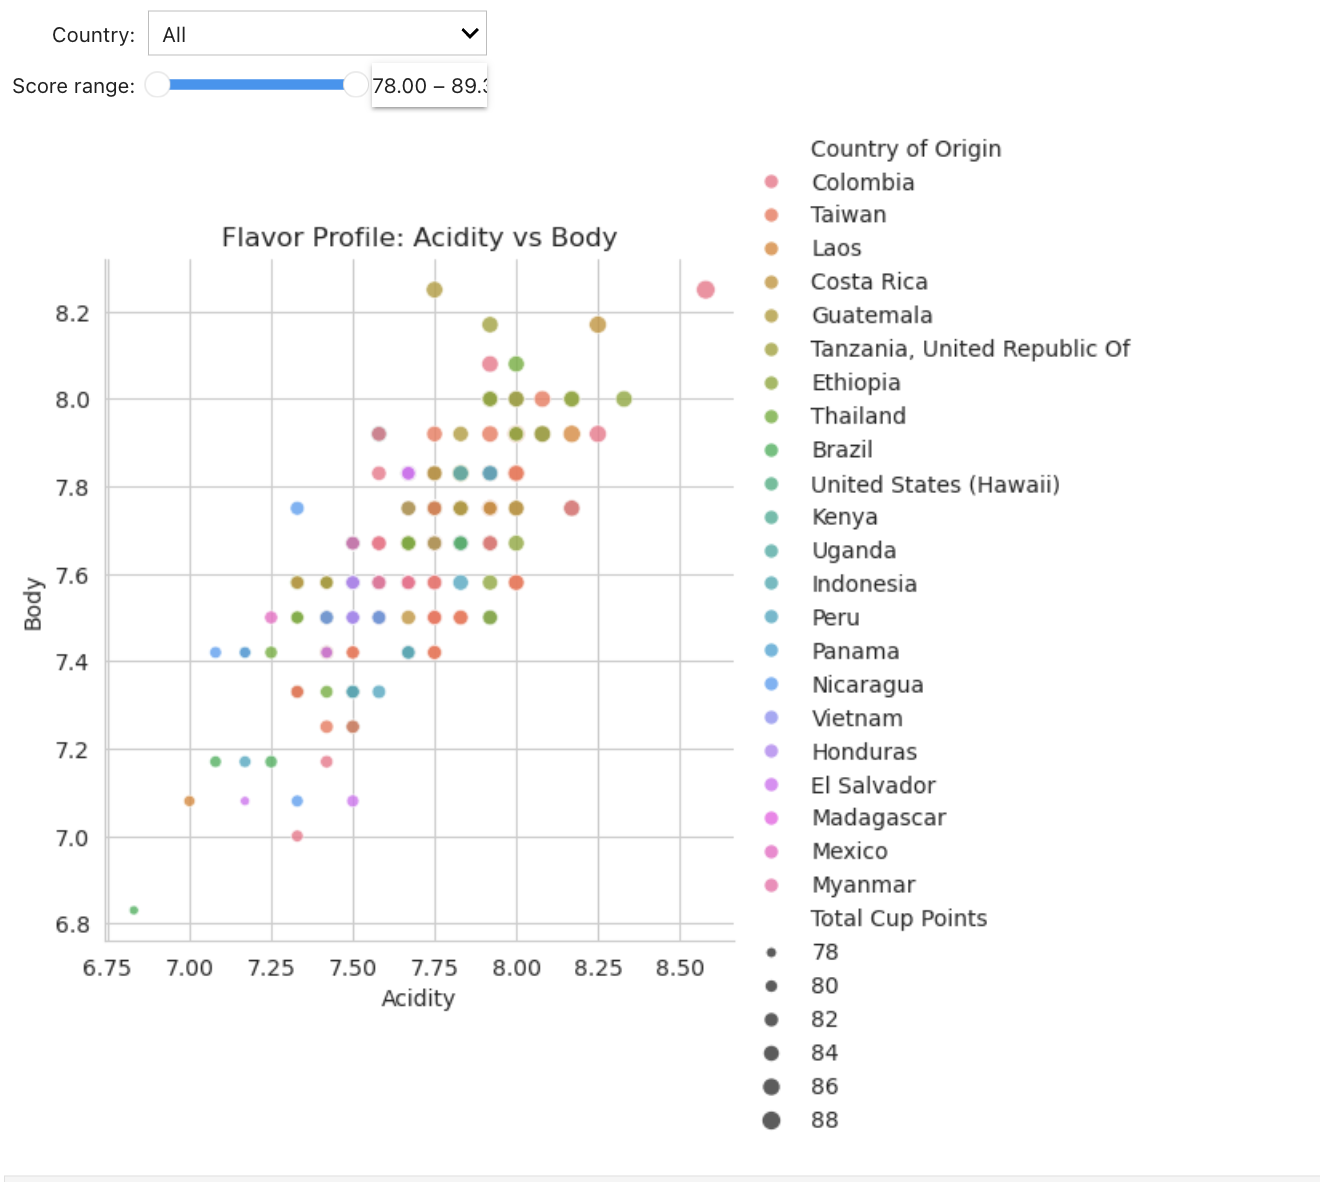

In [12]:
from IPython.display import Image, display
display(Image(filename="Plot_AcidityBody.png"))

In [9]:
attributes = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity',
              'Body', 'Balance', 'Sweetness', 'Overall']


country_widget = widgets.Dropdown(
    options=['All'] + sorted(df['Country of Origin'].dropna().unique().tolist()),
    value='All',
    description='Country:'
)

out = widgets.Output()

def country_profile(country):
    with out:
        clear_output(wait=True)

        df2 = df if country == 'All' else df[df['Country of Origin'] == country]

        means = df2[attributes].mean(numeric_only=True).dropna()
        if means.empty:
            print("No data available for that selection.")
            return

        sns.set_style('whitegrid')
        fig, ax = plt.subplots(figsize=(10, 4))
        sns.barplot(x=means.index, y=means.values, ax=ax)

        ax.set_title(f'Flavor Profile for {country}')
        ax.set_ylabel('Mean Score')
        ax.set_xlabel('Attribute')
        ax.tick_params(axis='x', rotation=45)

        plt.show()

ui = widgets.interactive(country_profile, country=country_widget)
display(ui, out)

interactive(children=(Dropdown(description='Country:', options=('All', 'Brazil', 'Colombia', 'Costa Rica', 'El…

Output()

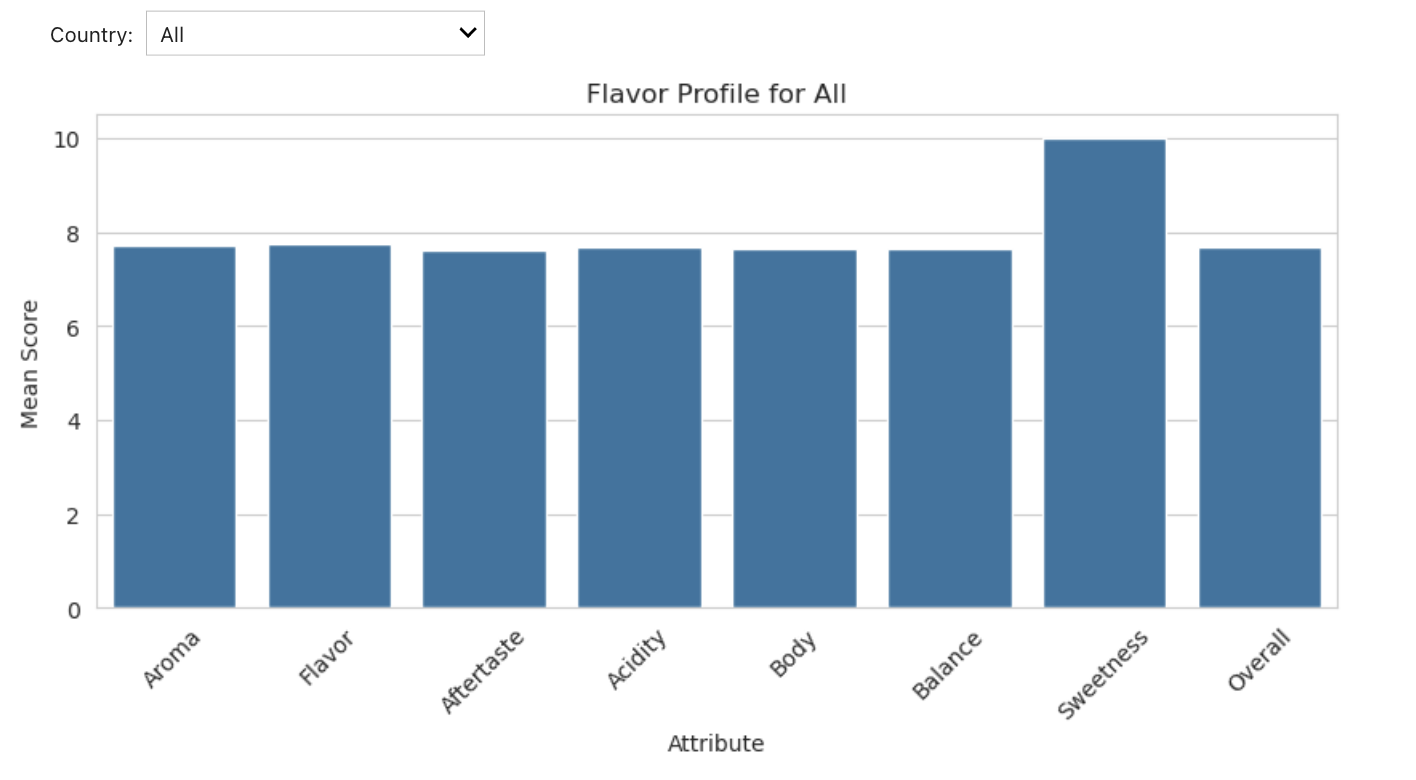

In [13]:
display(Image(filename="FlavorAttribute_score.png"))

In [16]:
flavor_cols = [
    'Aroma', 'Flavor', 'Aftertaste', 'Acidity',
    'Body', 'Balance', 'Sweetness', 'Overall'
]

flavor_widget = widgets.Dropdown(
    description='Attribute:',
    options=flavor_cols,
    value='Acidity'
)

def flavor_diff_plot(attribute):
    global_mean = df[attribute].mean()
    
    means = (
        df
        .groupby('Country of Origin')[attribute]
        .mean()
        .dropna()
    )
    

    diffs = means - global_mean

    diffs = diffs.sort_values()
    

    plt.figure(figsize=(10, 8))
    

    for i, (country, diff) in enumerate(diffs.items()):
        plt.plot([0, diff], [country, country], linewidth=1)  # line from 0 to the dot
    

    plt.scatter(diffs.values, diffs.index)
    

    plt.axvline(0, color='gray', linestyle='--', linewidth=1)
    
    plt.xlabel(f"{attribute} (difference from global mean)")
    plt.ylabel("Country of Origin")
    plt.title(f"Countries Above/Below Global Average {attribute}")
    plt.tight_layout()
    plt.show()

interact(flavor_diff_plot, attribute=flavor_widget);


interactive(children=(Dropdown(description='Attribute:', index=3, options=('Aroma', 'Flavor', 'Aftertaste', 'A…

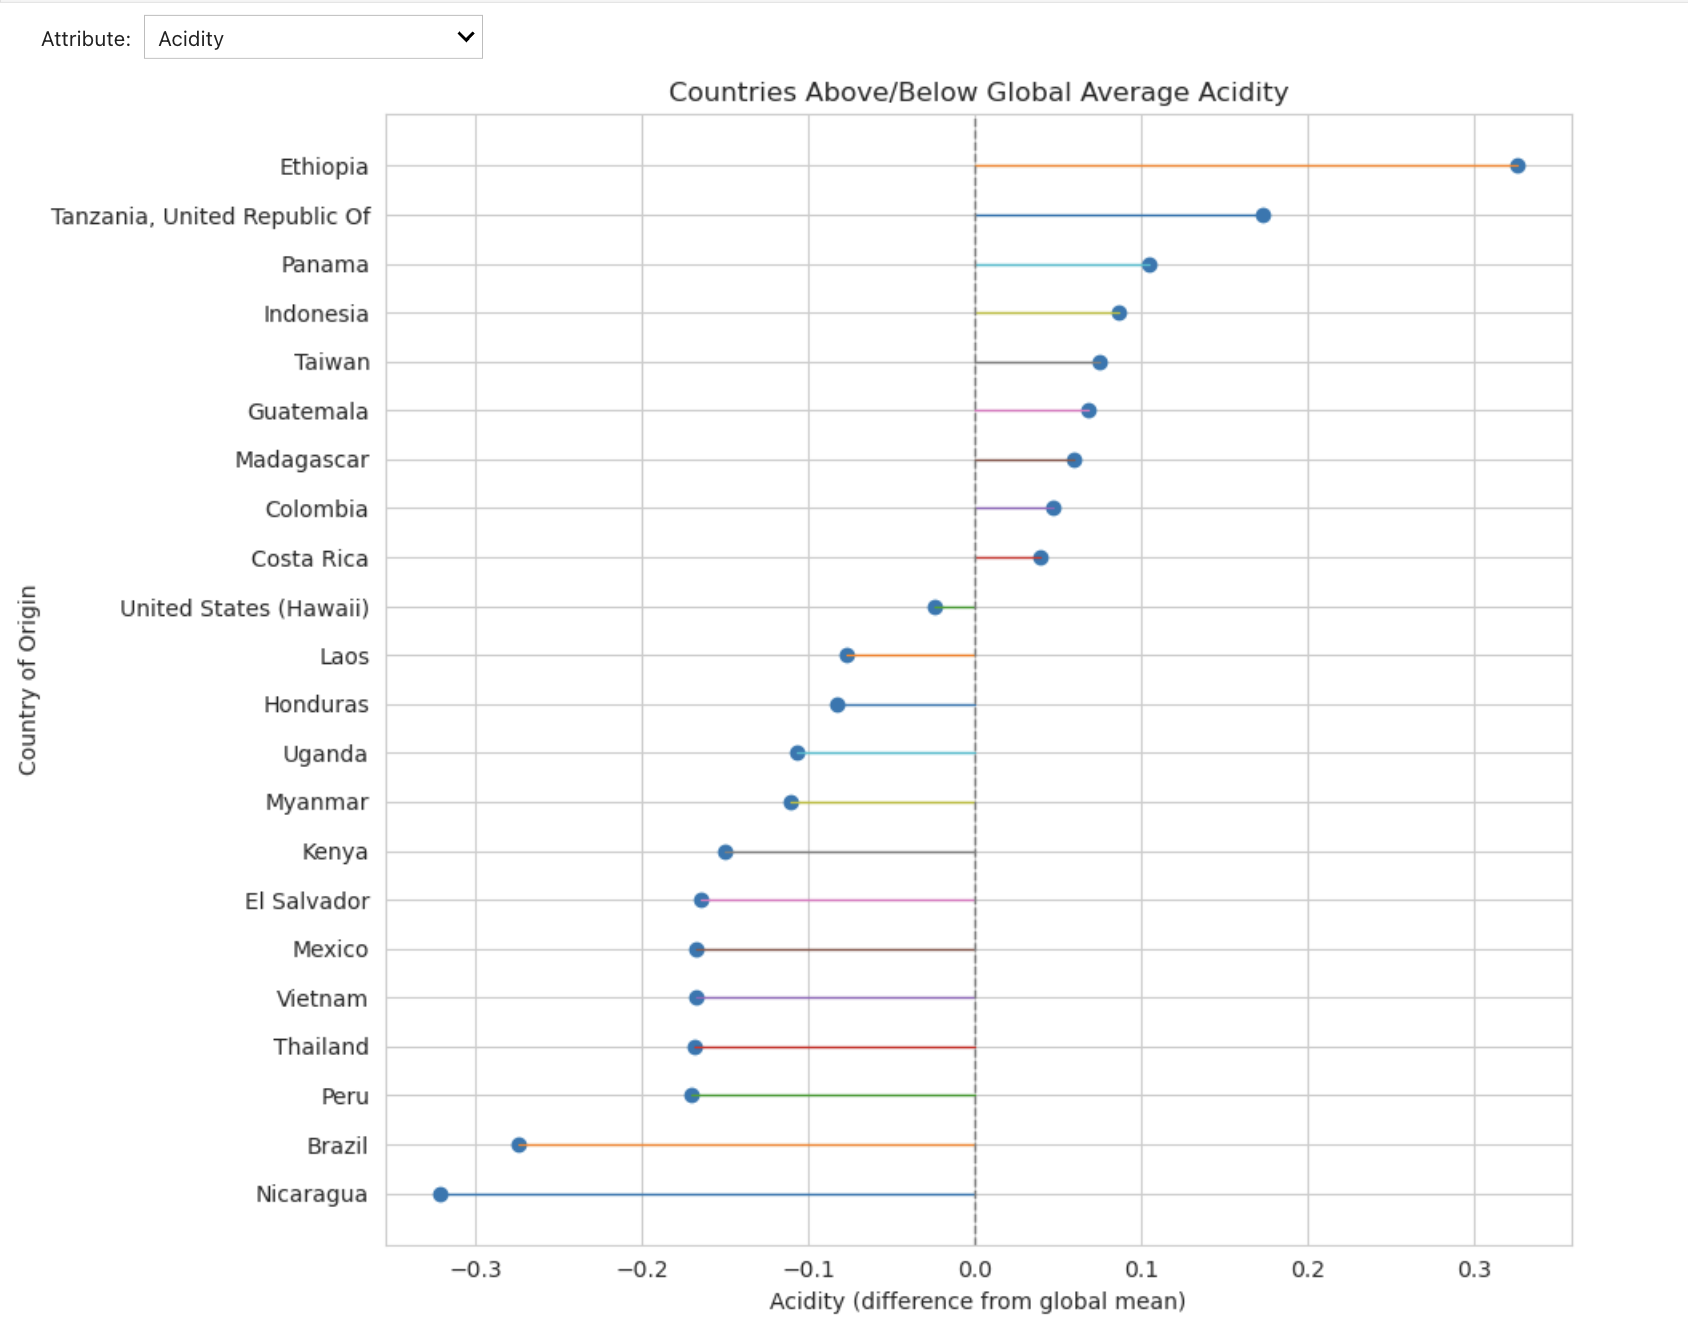

In [15]:
display(Image(filename="Global_Acidity.png"))

In [11]:
from ipywidgets import interact, IntSlider

TOTAL_COL = 'Total Cup Points'  

def total_points_diff_plot(min_samples=5):

    global_mean = df[TOTAL_COL].mean()
    

    stats = (
        df
        .groupby('Country of Origin')[TOTAL_COL]
        .agg(['mean', 'count'])
        .rename(columns={'mean': 'mean_points', 'count': 'n'})
        .dropna()
    )
    

    stats = stats[stats['n'] >= min_samples]
    if stats.empty:
        print("No countries with at least", min_samples, "samples.")
        return
    

    diffs = stats['mean_points'] - global_mean
    

    diffs = diffs.sort_values()
    

    plt.figure(figsize=(10, 8))
    
    for country, diff in diffs.items():
        plt.plot([0, diff], [country, country], linewidth=1)  # line from 0 to the dot
    
    plt.scatter(diffs.values, diffs.index)
    

    plt.axvline(0, color='gray', linestyle='--', linewidth=1)
    
    plt.xlabel("Total Cup Points (difference from global mean)")
    plt.ylabel("Country of Origin")
    plt.title("Countries Above/Below Global Average Total Cup Points")
    plt.tight_layout()
    plt.show()


interact(
    total_points_diff_plot,
    min_samples=IntSlider(description='Min # samples', min=1, max=30, step=1, value=5)
);

interactive(children=(IntSlider(value=5, description='Min # samples', max=30, min=1), Output()), _dom_classes=…

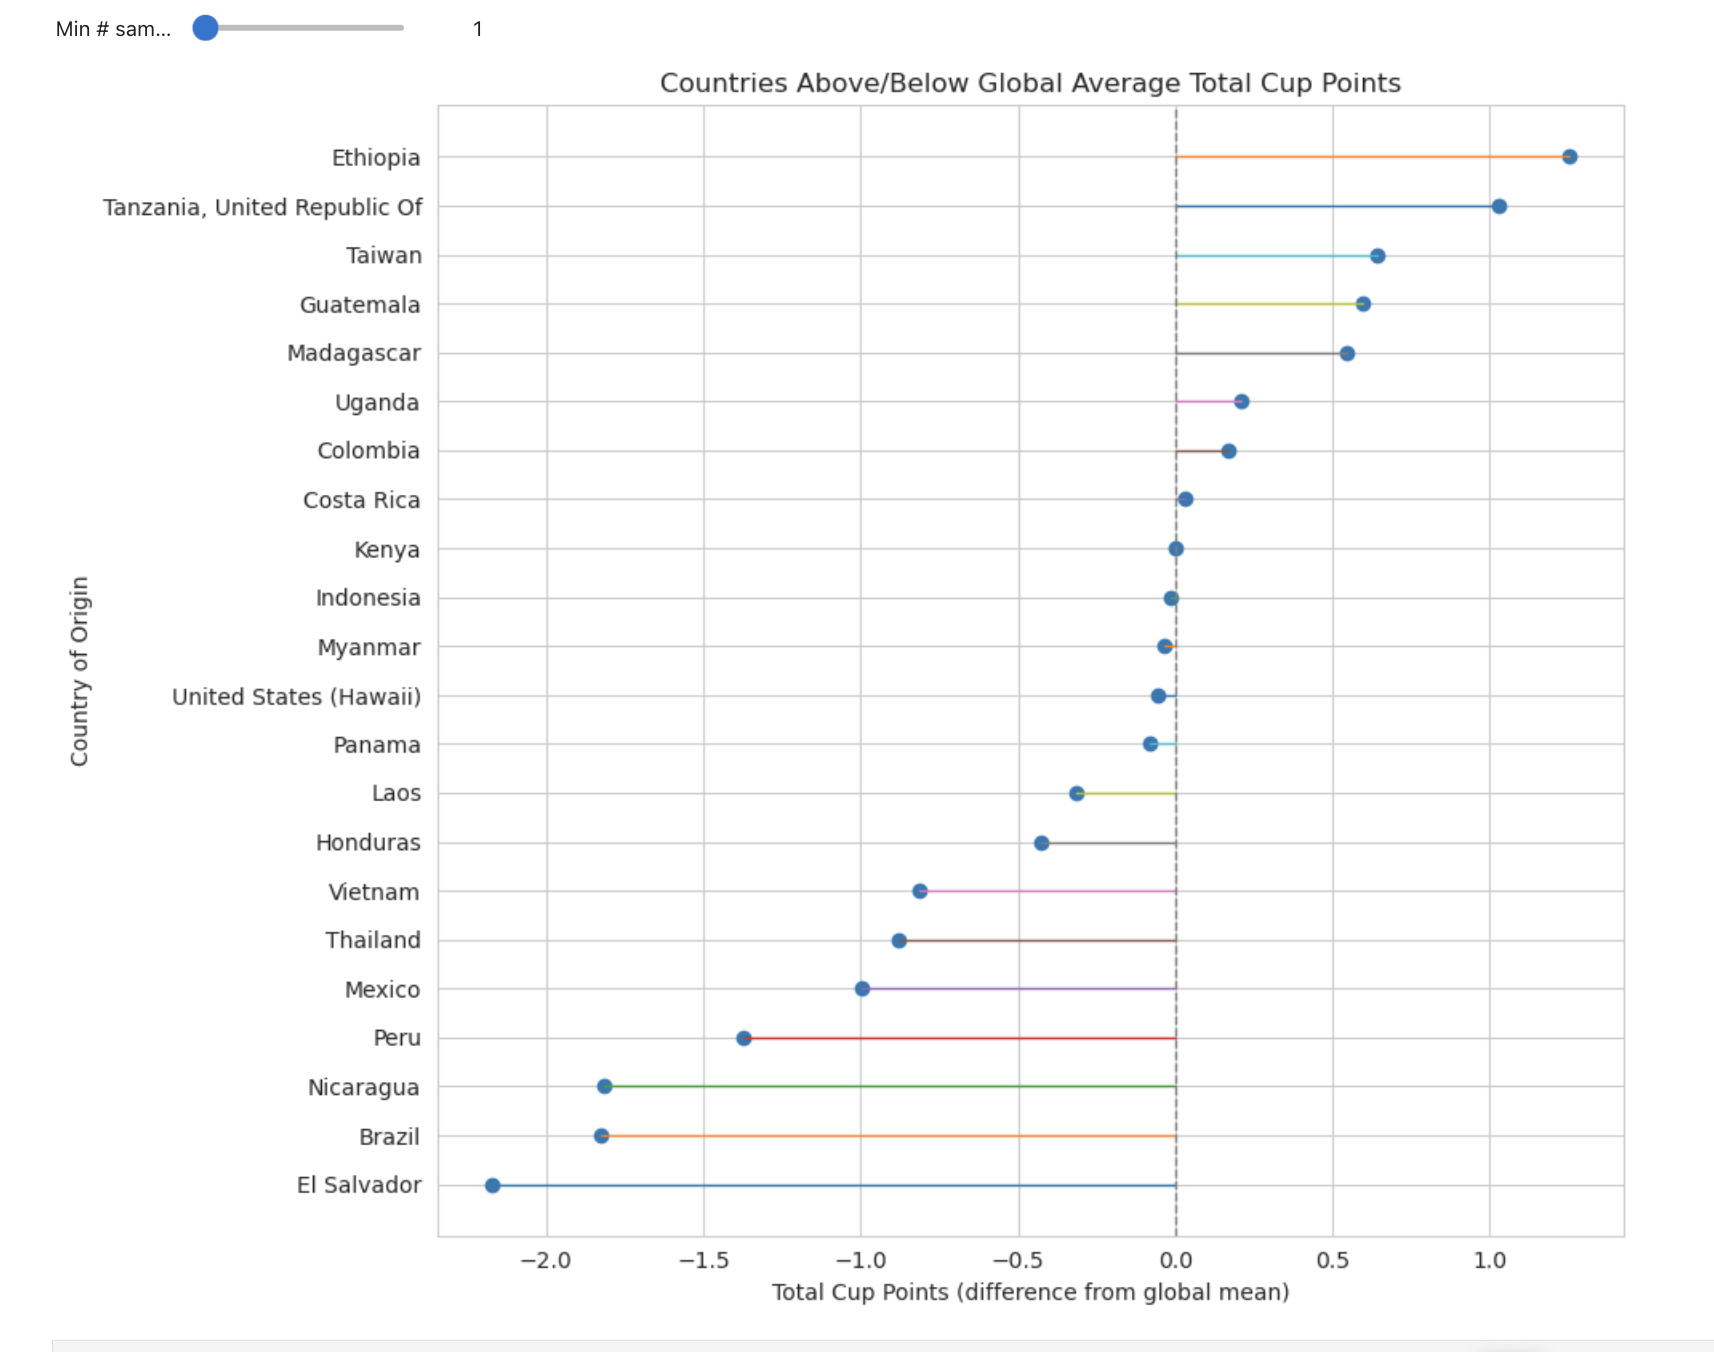

In [17]:
display(Image(filename="Average_Cup.png"))